In [1]:
%load_ext autoreload
%autoreload 2

## Synthetic Data Experiment

<br>
<b>Description</b> : This notebook evaluates the interaction model on synthetic data<br>
<b>Author</b> : Alma Andersson (andera29@gene.com)<br>
<b>Date</b> : 08/14/2024

In [2]:
import telegraph as tg
import anndata as ad 
import numpy as np
import scanpy as sc

import os
import os.path as os
import shutil

import os
from itertools import product
import pandas as pd
import numpy as np

## Helper Functions

## Load data

### Synthetic Data

In [3]:
SC_PTH = '/gstore/data/resbioai/andera29/cci-explore/validation/pipeline/data/common/hejin_map_tangramv2/sc/CID4465_sc.h5ad'

In [4]:
adata = ad.read_h5ad(SC_PTH)

In [5]:
label_col = 'celltype_major'

In [6]:
receiver_name, signaler_name = adata.obs[label_col].value_counts().index[0:2]

In [101]:
print(signaler_name, receiver_name)

Cancer Epithelial T-cells


In [7]:
np.random.seed(42)
ad_sp,ad_sc = tg.datagen.cellmix.cellmix.cellmix(adata.copy(),
                                                 n_spots = 100,
                                                 n_cells_per_spot= 10,
                                                 n_types_per_spot=5,
                                                 label_col=label_col,
                                                 signaler_names=signaler_name,
                                                 receiver_names=receiver_name,
                                                 n_interactions=1,
                                                 effect_size=10,
                                                 effect_direction='up',
                                                 signal_effect_base=0.99,
                                                 signal_effect_scaling=(2,5),  
                                                 p_inter=0.8,
                                                 p_signal_spots = 0.9,
                                                 encode_spatial = False,
                                                )

In [8]:
import scanpy as sc

In [9]:
ad_sc.obsm['spatial_lowres'] = ad_sc.obsm['spatial'].copy()

In [10]:
ad_sc.obsm['spatial'] = ad_sc.obsm['spatial'] + np.random.normal(0,0.1, size = (len(ad_sc),2))

In [11]:
import matplotlib.pyplot as plt

In [12]:
crd_low = ad_sc.obsm['spatial_lowres']

In [13]:
sc.pp.normalize_total(ad_sc,1e4)
sc.pp.log1p(ad_sc)

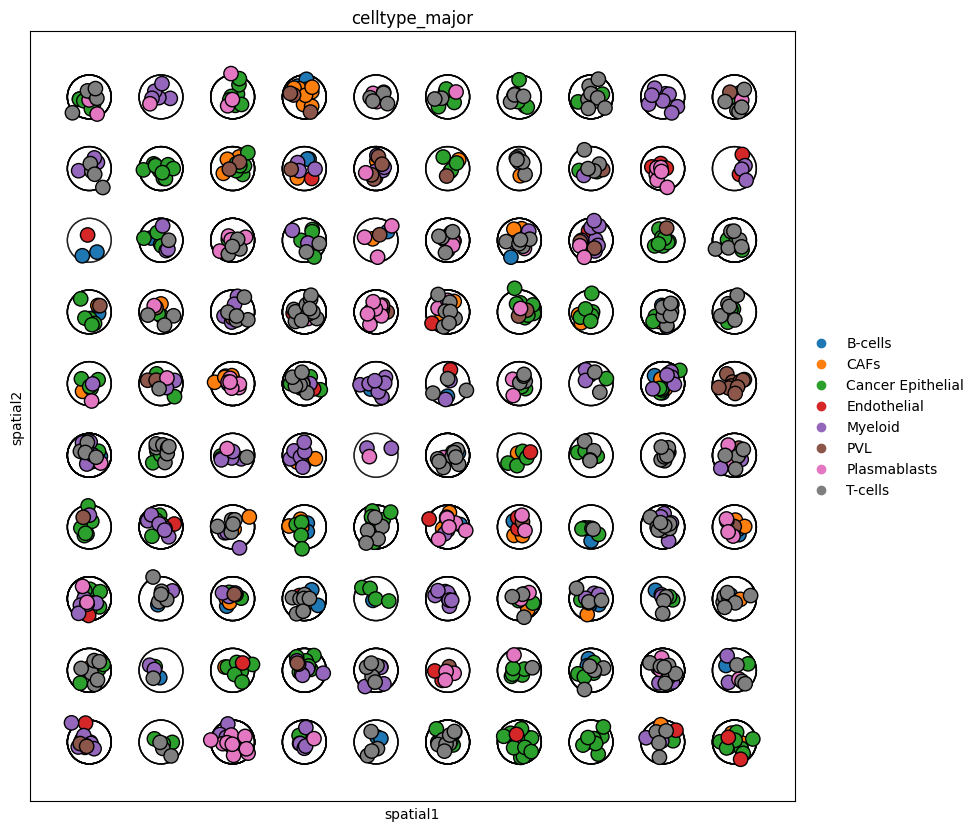

In [14]:
fig,ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.spatial(ad_sc, spot_size= 0.2, ax = ax, show = False, color=['celltype_major'], edgecolor = 'black')
ax.scatter(crd_low[:,0], crd_low[:,1], zorder = -100, s = 1000, facecolor = 'none', edgecolor = 'black', alpha = 0.5)
plt.show()

In [23]:
new_coords = tg.datagen.cellmix.cellmix._generate_coords(ad_sp.obsm['ct_proportions'])
ad_sp.obsm['spatial_encode'] = new_coords
new_sc_coords = new_coords[ad_sc.obs['spot_id'].values]
ad_sc.obsm['spatial_encode'] = new_sc_coords + np.random.normal(0,0.1, size = (len(ad_sc),2))

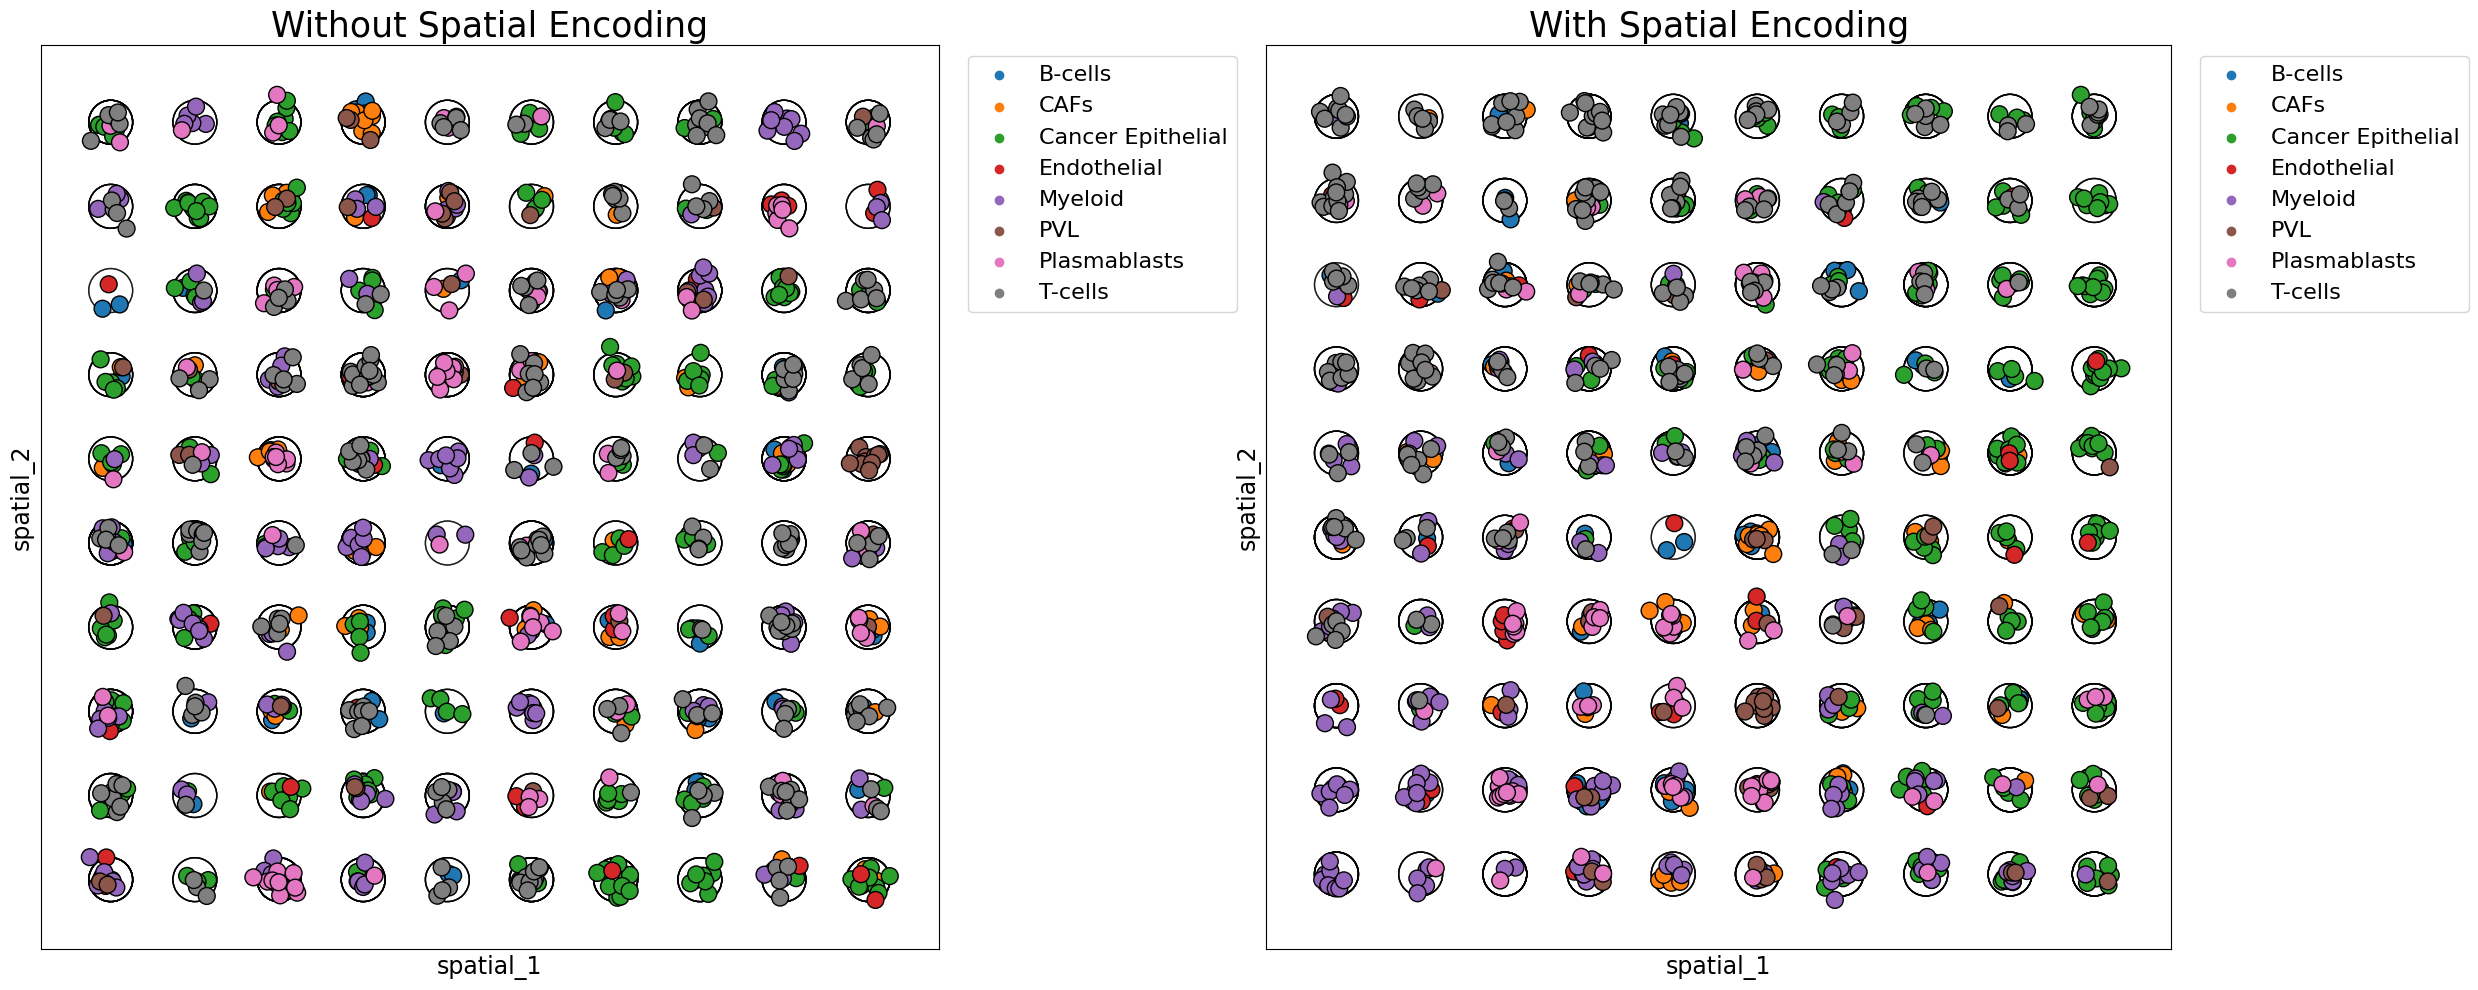

In [82]:
fig,ax = plt.subplots(1,2, figsize = (25,10))
sc.pl.spatial(ad_sc, spot_size= 0.2, ax = ax[0], show = False, color=['celltype_major'], edgecolor = 'black')
ax[0].scatter(crd_low[:,0], crd_low[:,1], zorder = -100, s = 1000, facecolor = 'none', edgecolor = 'black', alpha = 0.5)
ax[0].set_title('Without Spatial Encoding', fontsize = 25)

sc.pl.spatial(ad_sc, spot_size= 0.2, ax = ax[1], show = False, color=['celltype_major'], edgecolor = 'black', basis = 'spatial_encode')
ax[1].scatter(crd_low[:,0], crd_low[:,1], zorder = -100, s = 1000, facecolor = 'none', edgecolor = 'black', alpha = 0.5)
ax[1].set_title('With Spatial Encoding', fontsize = 25)


for axx in ax:
    axx.set_xlabel('spatial_1',fontsize = 17)
    axx.set_ylabel('spatial_2',fontsize = 17)
    axx.legend(fontsize=16,bbox_to_anchor=(1.02, 1), loc='upper left',)

fig.tight_layout()
plt.show()

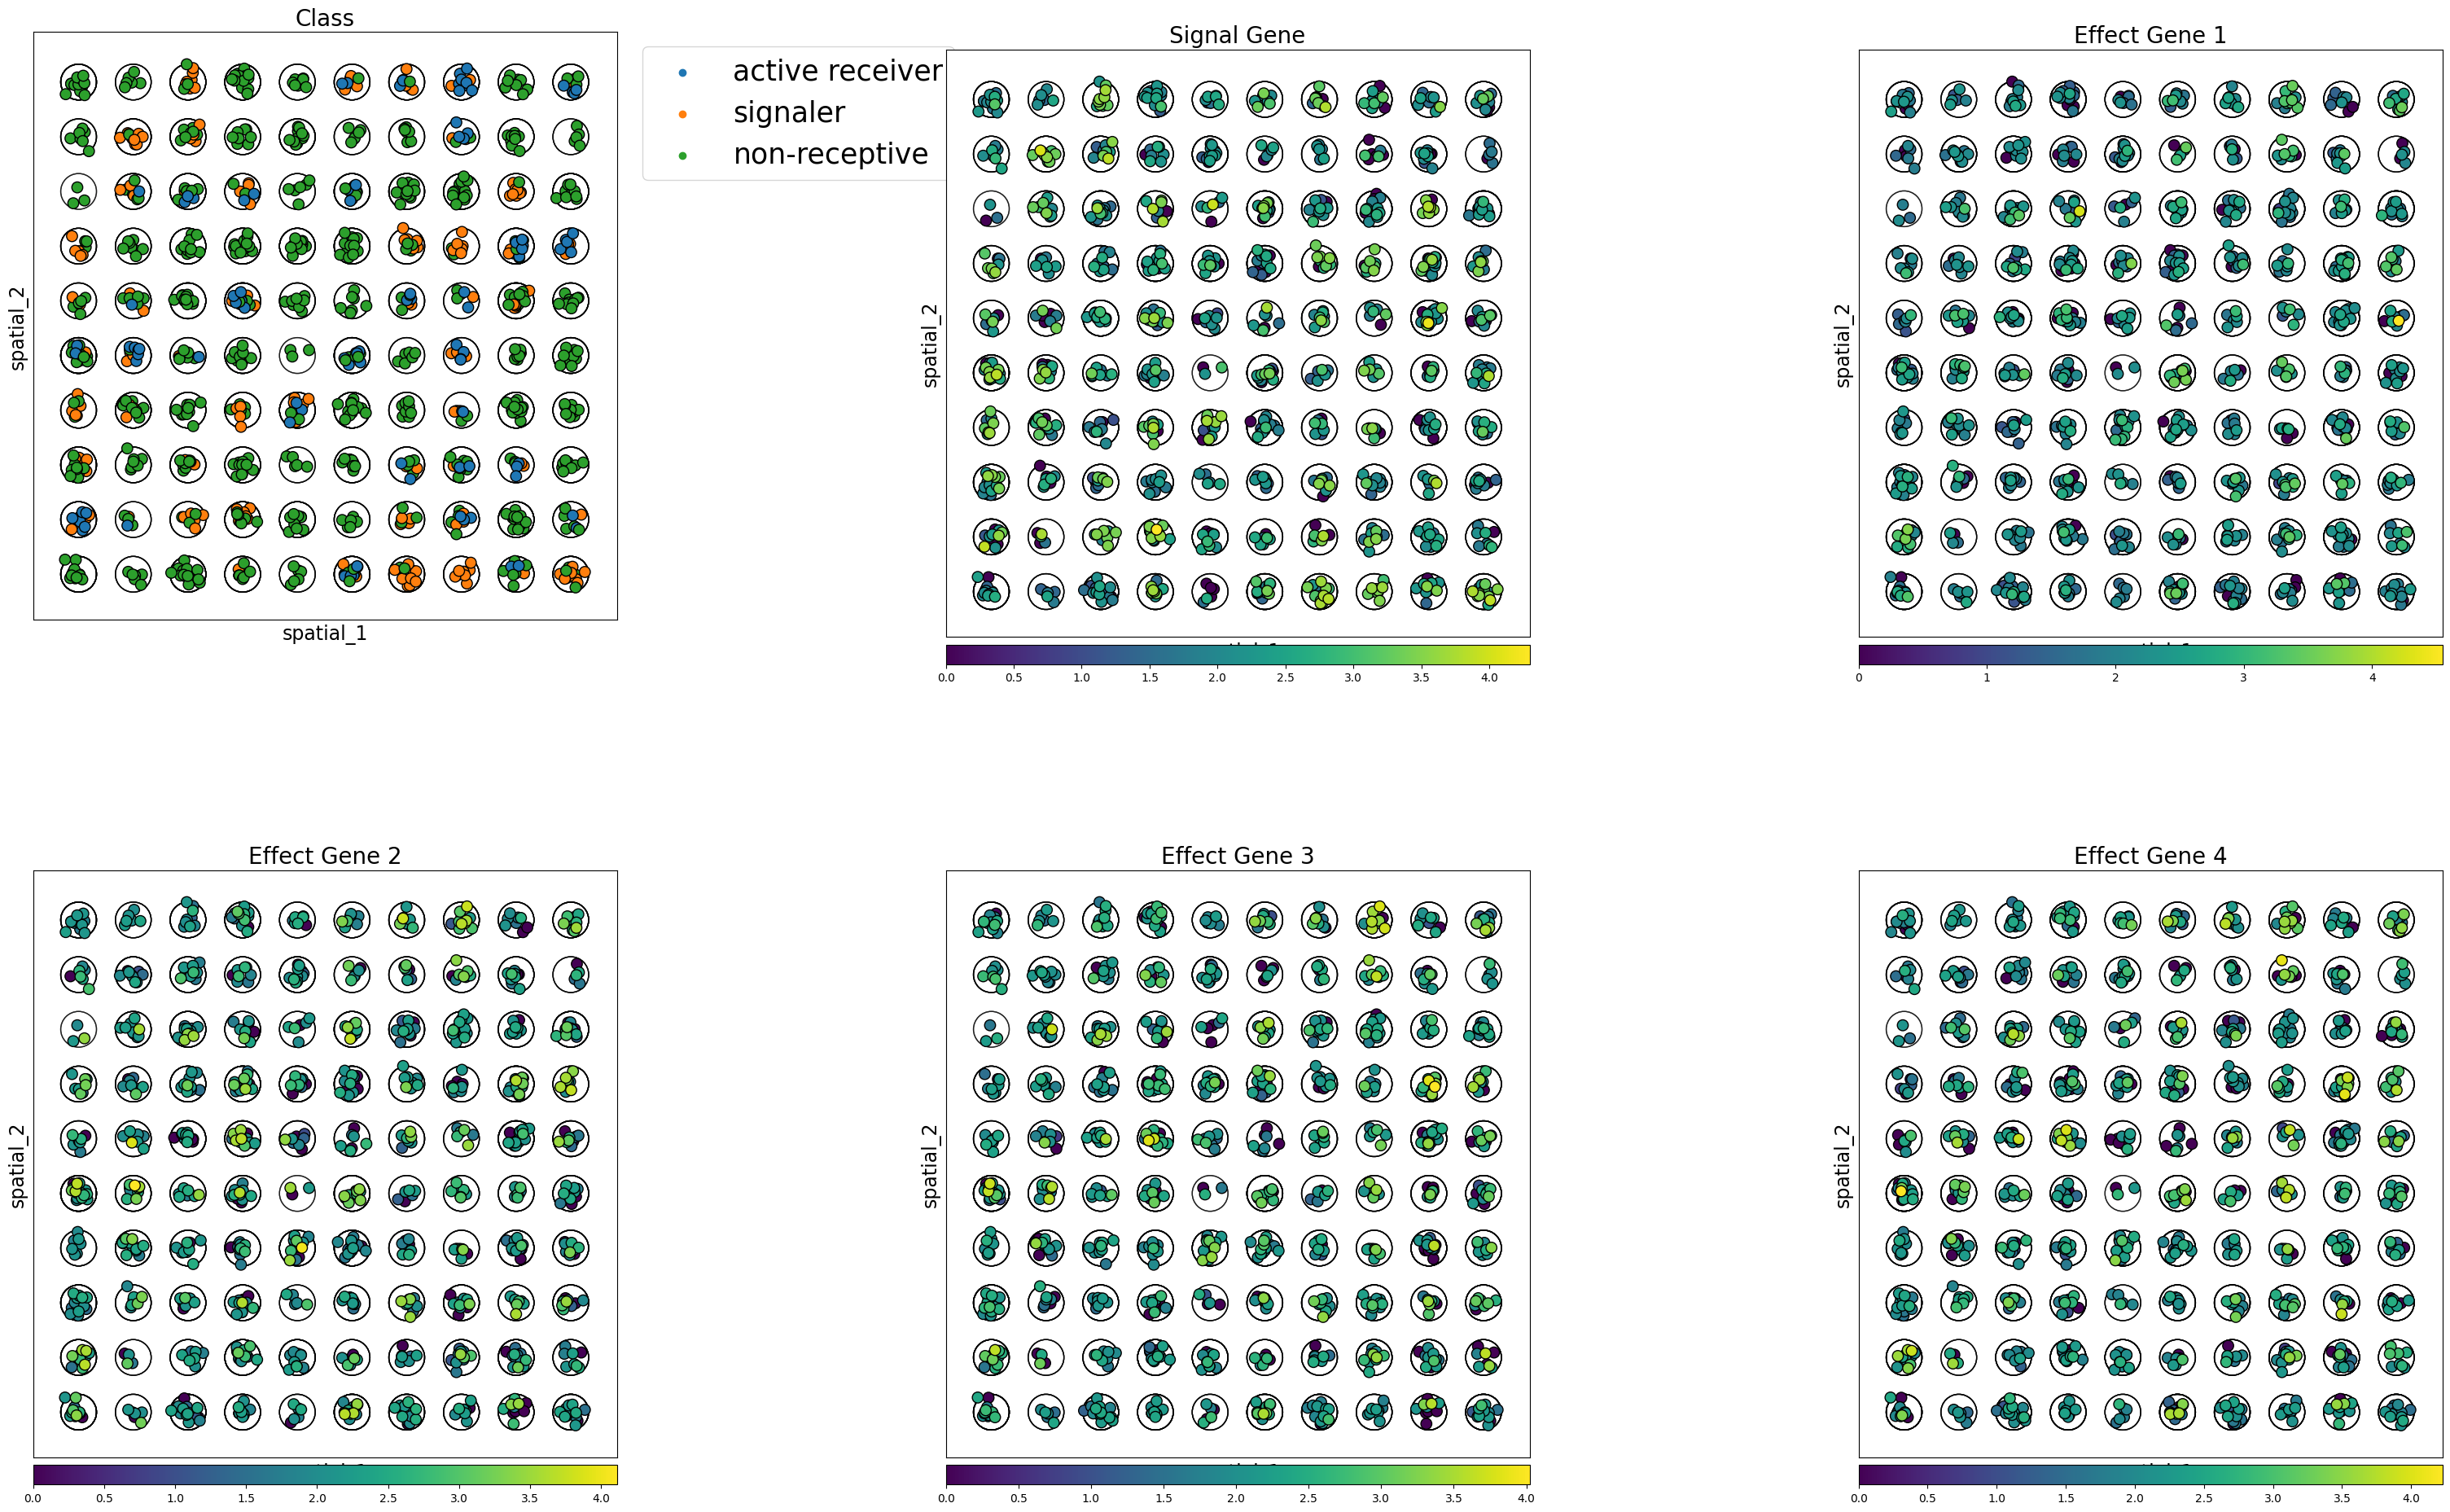

In [99]:
fig,ax = plt.subplots(2,3, figsize = (30,20))

ax = ax.flatten()

ad_sc.obs['pretty_S_R_0'] = ad_sc.obs['S_R_0'].map(dict(S = 'signaler', R = 'active receiver', none = 'non-receptive'))

sc.pl.spatial(ad_sc, spot_size= 0.2, ax = ax[0], show = False, color=['pretty_S_R_0'], edgecolor = 'black')
ax[0].scatter(crd_low[:,0], crd_low[:,1], zorder = -100, s = 1000, facecolor = 'none', edgecolor = 'black', alpha = 0.5)
ax[0].set_title('Class', fontsize = 20)


colors = ['signal_0'] + [f'effect_0_{k}' for k in range(0,4)]

for _k, color in enumerate(colors):

    k = _k + 1
    
    sc.pl.spatial(ad_sc, spot_size= 0.2, ax = ax[k], show = False, color=color ,edgecolor = 'black',colorbar_loc='bottom', )
    ax[k].scatter(crd_low[:,0], crd_low[:,1], zorder = -100, s = 1000, facecolor = 'none', edgecolor = 'black', alpha = 0.5)

ax[1].set_title('Signal Gene', fontsize = 20)
for k,axx in enumerate(ax[2::]):
    axx.set_title(f'Effect Gene {k+1}', fontsize = 20)

for axx in ax:
    axx.set_xlabel('spatial_1',fontsize = 17)
    axx.set_ylabel('spatial_2',fontsize = 17)


ax[0].legend(fontsize=25,bbox_to_anchor=(1.02, 1), loc='upper left')

fig.subplots_adjust(bottom = 0.2)
fig.tight_layout()
plt.show()

In [49]:
sc.pp.pca(ad_sc)
sc.pp.neighbors(ad_sc)
sc.tl.umap(ad_sc)

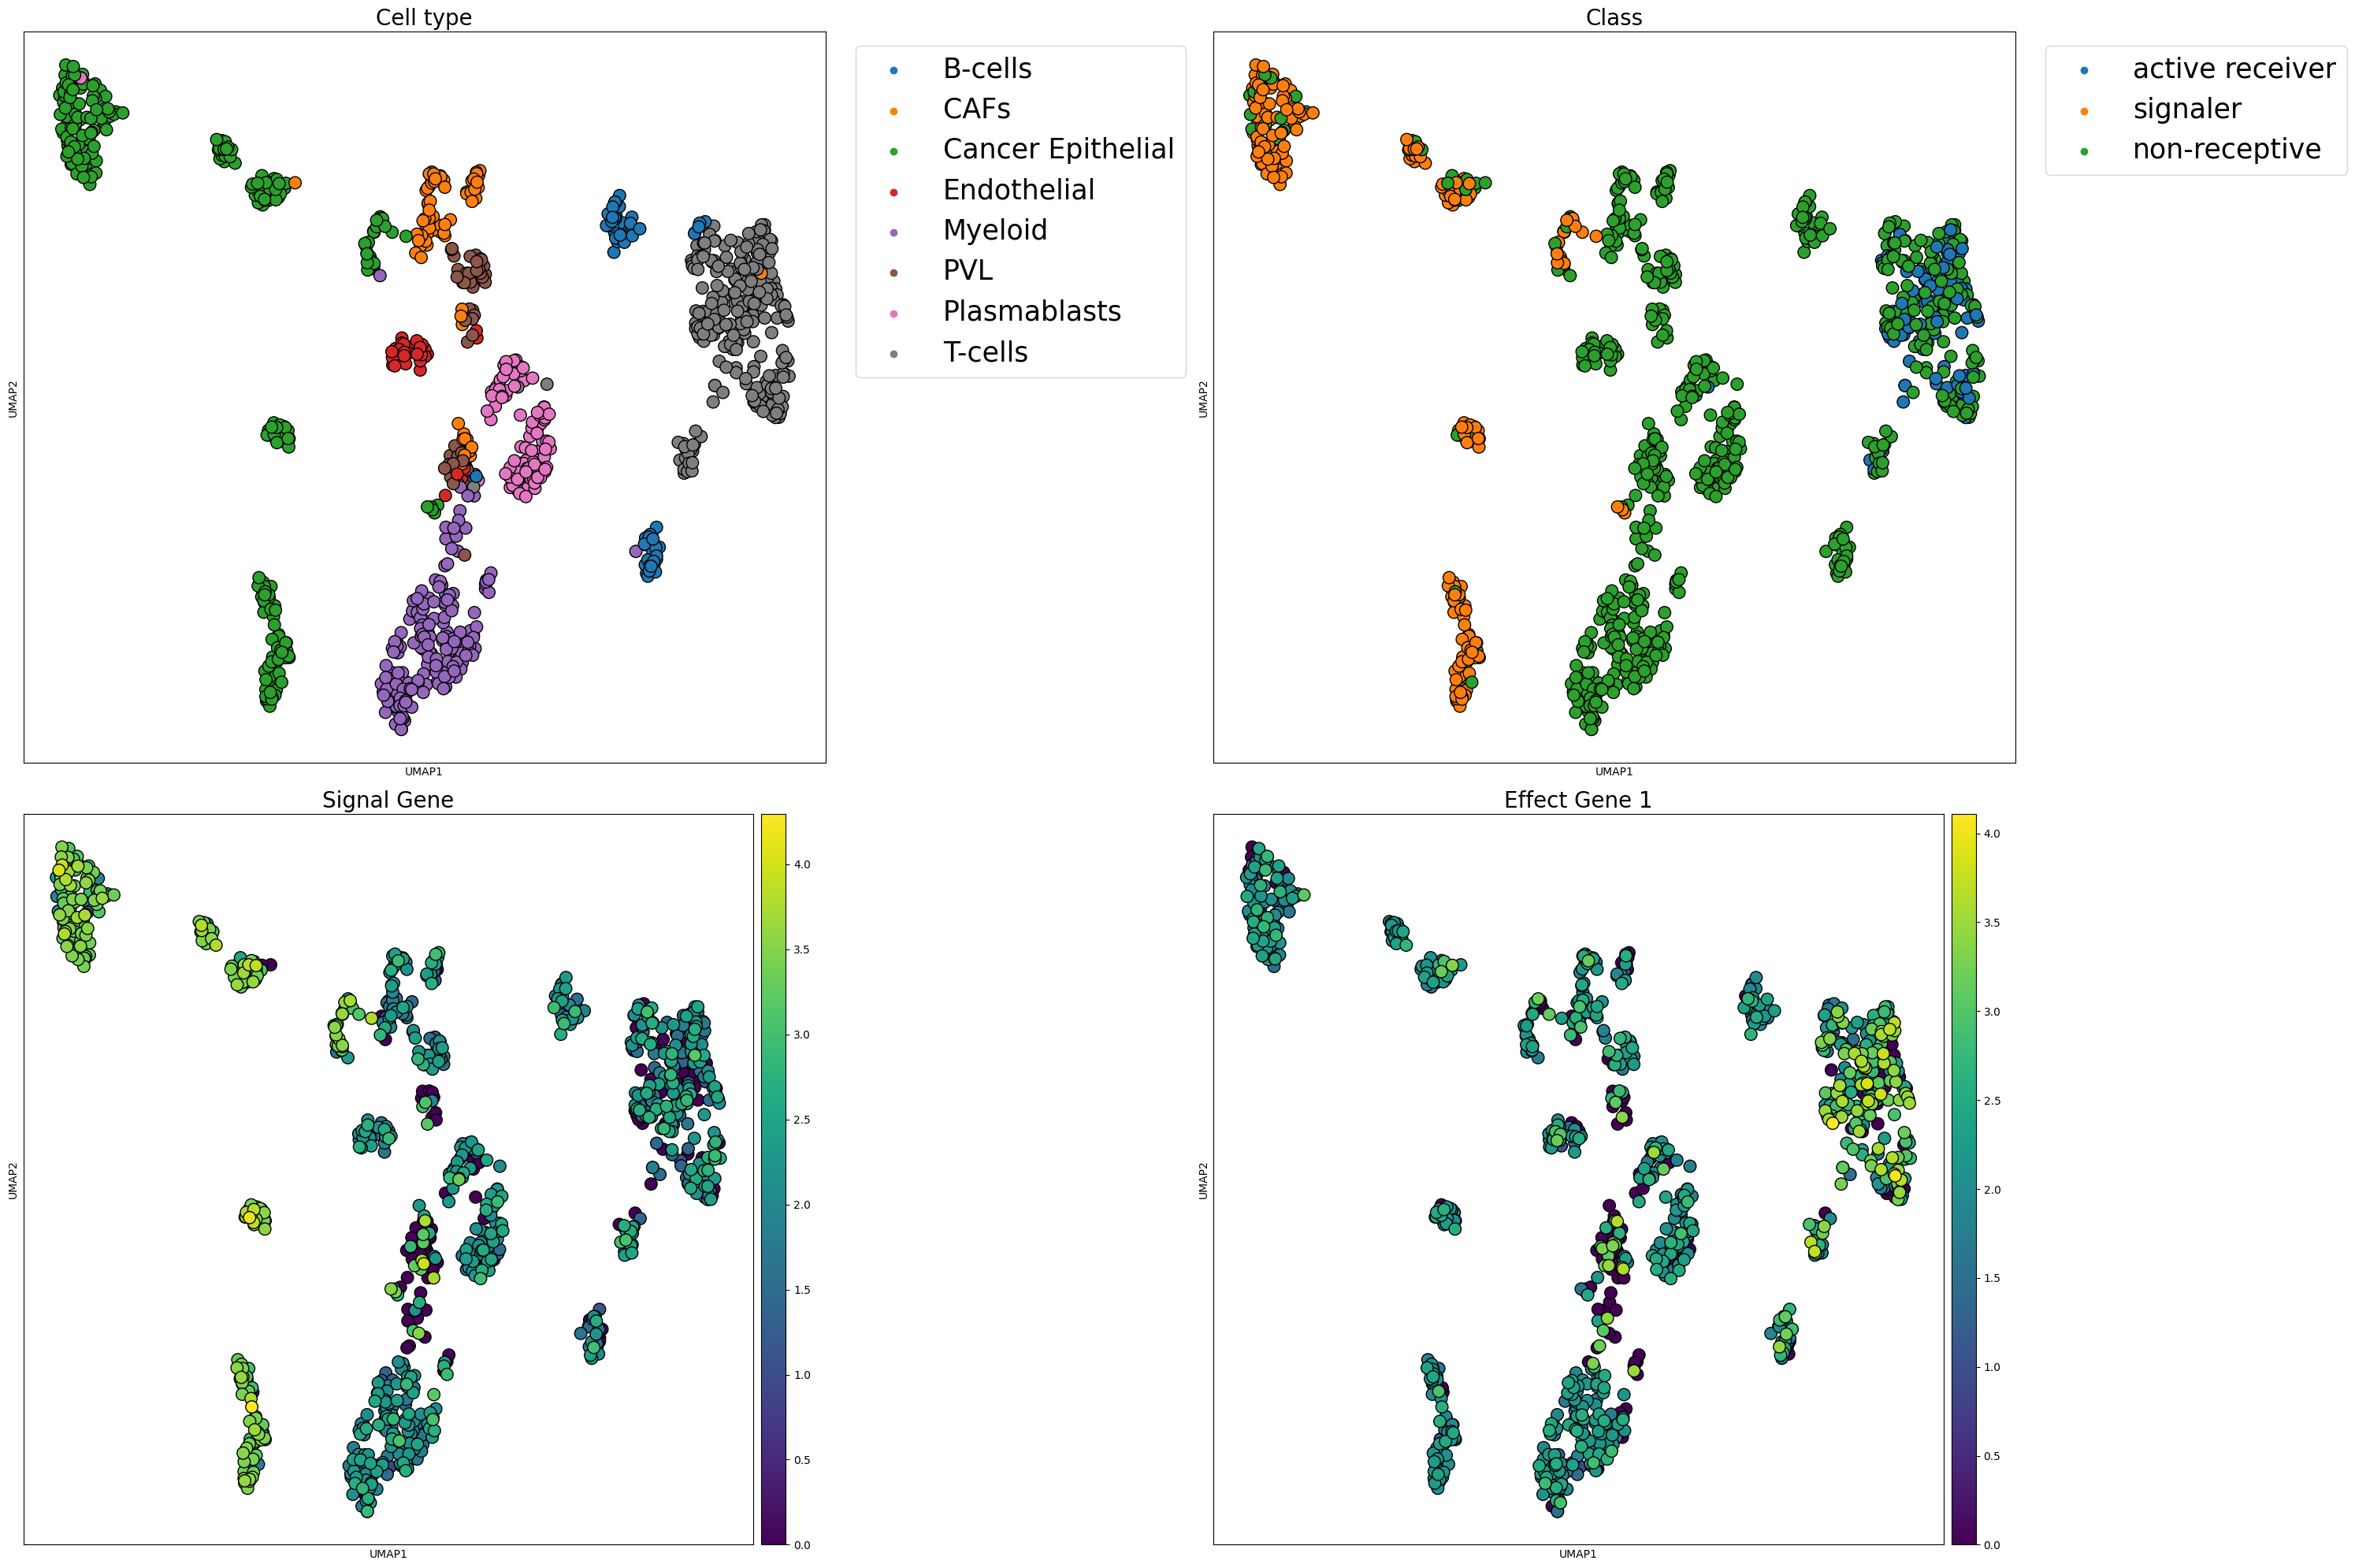

In [88]:
fig, ax = plt.subplots(2,2, figsize = (30,20))

ax = ax.flatten()

colors = ['celltype_major','pretty_S_R_0','signal_0','effect_0_1']

for k,color in enumerate(colors):
    sc.pl.umap(ad_sc, color = color, ax = ax[k], show=False, size=500, edgecolor='black')


ax[2].set_title(f'Signal Gene',fontsize = 20)
ax[3].set_title(f'Effect Gene {1}', fontsize =20)
ax[0].set_title('Cell type', fontsize = 20)
ax[1].set_title('Class', fontsize = 20)

ax[0].legend(fontsize=25,bbox_to_anchor=(1.02, 1), loc='upper left')
ax[1].legend(fontsize=25,bbox_to_anchor=(1.02, 1), loc='upper left')


fig.tight_layout()